In [3]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm

In [4]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib


In [5]:
%matplotlib notebook

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [7]:
experiment = 'gratings'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
n_resamples=20
print(responsive_test, responsive_thr)
#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters) #, 
#                             n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)
#### Set current output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'gratings_%s_%s' % (response_type, responsive_test),
                       'pref_theta')
print(dst_dir)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta


#### Metadata

In [8]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


#### Tuning curve fits

In [10]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, create_new=False,
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(float)

#### Only take good fits

In [15]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()

In [16]:
# Unique datasets, get dsets with most ncells pass
min_ncells=0
gof_thr=0.5
drop_repeats=True
counts = aggr.count_n_cells(bestg[bestg['gof']>gof_thr], 
                            name='n_cells', reset_index=True)
print("All cells pass (GoF>%.2f)" % gof_thr)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
FITS = pd.concat([g for (va, dk), g in bestg[bestg['gof']>gof_thr].groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
ncells_fit = aggr.count_n_cells(FITS)
print("Unique datasets (pass, GoF>%.2f)" % gof_thr)
print(ncells_fit.groupby('visual_area').sum().to_markdown())

All cells pass (GoF>0.50)
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |        98 |
| Lm            |       227 |
| V1            |       443 |
Unique datasets (pass, GoF>0.50)
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |        70 |
| Lm            |       219 |
| V1            |       443 |


<IPython.core.display.Javascript object>


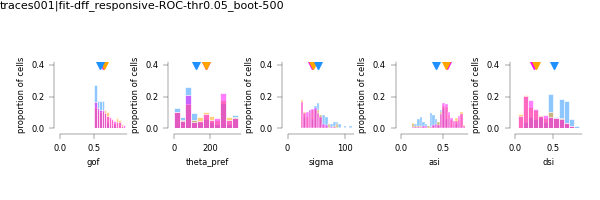

No handles with labels found to put in legend.


gof                                                    \
             count      mean       std       min       25%       50%   
visual_area                                                            
Li            70.0  0.592327  0.070506  0.500949  0.533673  0.581998   
Lm           219.0  0.663663  0.113786  0.500364  0.566954  0.644274   
V1           443.0  0.652473  0.114170  0.500356  0.559315  0.630307   

                                theta_pref              ...       asi  \
                  75%       max      count        mean  ...       75%   
visual_area                                             ...             
Li           0.631682  0.804430       70.0  150.297376  ...  0.516601   
Lm           0.740455  0.944066      219.0  176.460721  ...  0.647360   
V1           0.728501  0.949841      443.0  173.473995  ...  0.632950   

                         dsi                                          \
                  max  count      mean       std       min       25%   
visual_area                                                            
Li           0.709534   70.0  0.497754  0.170808  0.127905  0.400377   
Lm           0.776989  219.0  0.315138  0.189321  0.033673  0.148536   
V1           0.768169  443.0  0.306639  0.179704  0.034921  0.157450   

                                           
                  50%       75%       max  
visual_area                                
Li           0.519317  0.637550  0.841348  
Lm           0.273131  0.478197  0.804189  
V1           0.253692  0.436537  0.788286  

[3 rows x 40 columns]

In [27]:
%matplotlib notebook
means_= FITS.groupby('visual_area').median()
plot_params = ['gof', 'theta_pref', 'sigma', 'asi', 'dsi' ]
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,2))
ylim=0.4
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=FITS, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    #ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    #ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25, right=0.97, wspace=0.7)
sns.despine(offset=4)

pplot.label_figure(fig, data_id)
figname = 'hist_per-area_metrics_gof%.2f' % gof_thr
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

FITS.groupby(['visual_area'])[plot_params].describe()

#### Trial responses

In [20]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs
Stimulus: gratings (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |           885 |
| Lm |           473 |
| Li |           444 |
|    |   visual_area |
|:---|--------------:|
| Li |            16 |
| Lm |             9 |
| V1 |             8 |


In [21]:
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

FINAL totals: gratings (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       309 |        11 |
| Lm            |       462 |         8 |
| V1            |       885 |         8 |


In [48]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [33]:
# Add position info for each cell
FITS['experiment'] = 'gratings'
FITS = aggr.add_roi_positions(FITS.copy())

# Tuning curves

In [271]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [272]:
angdists = cr.aggregate_tuning_curve_ccdist(FITS, min_ncells=5)

too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Li, 20190522_JC089_fov1
too few cells: Li, 20190617_JC099_fov1
too few cells: Li, 20191105_JC117_fov1
too few cells: Li, 20191111_JC120_fov1
too few cells: Lm, 20191105_JC117_fov1


In [292]:
angdists.groupby('visual_area').count()

,xcorr,pearsons,cell_1,cell_2,neuron_pair,cortical_distance,datakey,n_cells
visual_area,,,,,,,,
Li,422,422,422,422,422,422,422,422
Lm,4377,4377,4377,4377,4377,4377,4377,4377
V1,14610,14610,14610,14610,14610,14610,14610,14610


In [282]:
dist_params = ['xcorr', 'pearsons', 'cortical_distance', 'n_cells' ]
for p in dist_params:
    angdists[p] = angdists[p].astype(float)
means_= angdists.groupby('visual_area').median()
means_

,xcorr,pearsons,cell_1,cell_2,cortical_distance,n_cells
visual_area,,,,,,
Li,0.181397,0.051735,50,237,247.322673,22.0
Lm,0.181228,-0.017843,78,180,398.276626,51.0
V1,0.176700,0.058302,89,221,362.388221,77.0


<IPython.core.display.Javascript object>


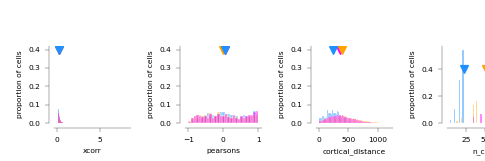

No handles with labels found to put in legend.


In [284]:
%matplotlib notebook
means_= angdists.groupby('visual_area').median()
plot_params = ['xcorr', 'pearsons', 'cortical_distance', 'n_cells' ]
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,2))
ylim=0.4
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=angdists, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    #ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    #ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    #ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25, right=0.97, wspace=0.7)
sns.despine(offset=4)

# pplot.label_figure(fig, data_id)
# figname = 'hist_per-area_metrics_gof%.2f' % gof_thr
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# FITS.groupby(['visual_area'])[plot_params].describe()

In [294]:
df = angdists.copy()
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

In [295]:
angdists.columns

Index(['xcorr', 'pearsons', 'cell_1', 'cell_2', 'neuron_pair',
       'cortical_distance', 'visual_area', 'datakey', 'n_cells'],
      dtype='object')

<IPython.core.display.Javascript object>


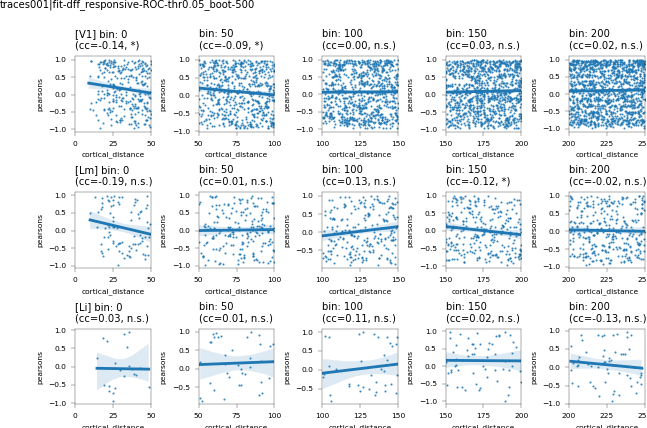

In [296]:
%matplotlib notebook
y_var='pearsons'
dist_var = 'cortical_distance'
scatter_kws={'s': 0.5}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,5.3))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([ctx_bins[di], ctx_bins[di+1]])
        ax.set_xticks(np.linspace(ctx_bins[di], ctx_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

# figname = '%s_v_binCTX_%ium_cc' % (y_var, ctx_step)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

In [308]:
df = angdists.copy()
# Split distances into X um bins
ctx_step=25
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

<IPython.core.display.Javascript object>


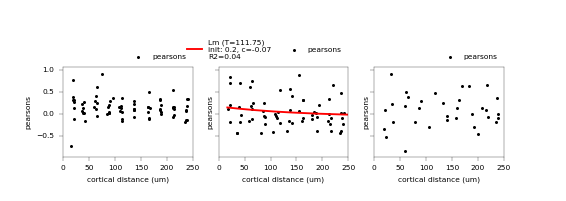

    val out of bounds
BINNED, no fit: Li
    val out of bounds
BINNED, no fit: V1


In [321]:
%matplotlib notebook
n_iter=int(np.random.rand(1)[0]*500)
y_var = 'pearsons'

min_npairs = 5
x_var = 'binned_%s' % dist_var
fit_sites = True
xlabel='cortical distance (um)' if dist_var=='cortical_distance' \
            else 'RF distance (deg)'
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
col_selector = ['visual_area', 'cell_1', 'cell_2', 'neuron_pair', dist_var, y_var] 
col_selector.extend(cnt_grouper)
# plot
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, vg in df.groupby('visual_area'):
    
    cc0 = vg[col_selector].copy()
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>=min_npairs].index.tolist(),
                               cnts[cnts>=min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc0[col_selector]\
                    .groupby(cnt_grouper).median().reset_index().dropna()
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()
    # plot
    meas_cc = cc0.groupby(cnt_grouper).median().reset_index().dropna()
    ax=axn[visual_areas.index(va)]
    ax.scatter(x=dist_var, y=y_var, data=meas_cc, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=False,
                                            normalize_x=True, func='halflife',
                                            estimator='median', metric=y_var,
                                            to_quartile=dist_var, return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    ax.set_ylabel(y_var)
    ax.set_xlabel(xlabel)

    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=2)
    ax.set_xlim([0, 250])
    #ax.set_ylim([-0.5, 0.7])
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)


In [302]:
ctx_step=25
max_dist=400

df = angdists[angdists.cortical_distance<=max_dist].copy()
ctx_dist_bins = np.arange(0, max_dist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_dist_bins, metric='cortical_distance')

grp_step=50
grp_bins = np.arange(0, 1000+grp_step, grp_step)
df['distance_group'] = pd.cut(df['cortical_distance'], \
                                                grp_bins, include_lowest=True,
                                                labels=grp_bins[0:-1])
df['distance_group_label'] = [int(d) if not np.isnan(d) else d \
                             for d in df['distance_group'].values]

<IPython.core.display.Javascript object>


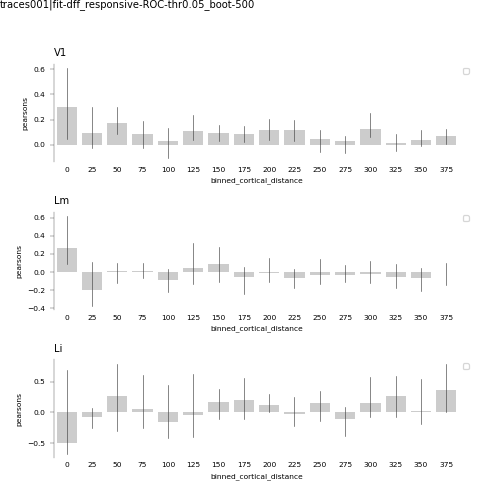

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [307]:
y_var = 'pearsons'
# Ticks
min_npairs=0 #10
sorted_x_vars = [k for k, v in df.groupby(x_var) if k<max_dist]
# Colors
vals_ = grp_bins[grp_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
grp_colors = dict((k, v) for k, v in zip(vals_, cols_))

fig, axn = pl.subplots(3, 1, figsize=(6,6))
for va, vg in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.barplot(x='binned_cortical_distance', y=y_var, ax=ax, data=vg,
                color=[0.8]*3, dodge=False, estimator=np.median, errwidth=0.5)
#     sns.stripplot(x='binned_cortical_distance', y=y_var, ax=ax, data=vg,
#                   hue='distance_group_label', dodge=False, size=2, 
#                   palette=grp_colors)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', markerscale=0.5)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_title(va, loc='left', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.15, hspace=0.5)
sns.despine(bottom=True)

pplot.label_figure(fig, data_id)

0.36761319637298584 8.407405363850964e-35
0.6169183254241943 1.486627731712948e-39


<IPython.core.display.Javascript object>


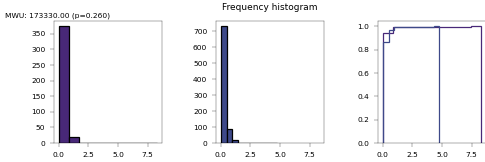

In [305]:
y_var='xcorr'
col1=grp_colors[0]
col2=grp_colors[50]
v1 = df[df.distance_group_label==0][y_var].values
v2 = df[df.distance_group_label==50][y_var].values
# testd = pd.DataFrame({'v1': v1, 'v2': v2})
w, pvalue = spstats.shapiro(v1)
print(w, pvalue)
w, pvalue = spstats.shapiro(v2)
print(w, pvalue)

fig, (ax1, ax2, ax3) = pl.subplots(1, 3, sharex=True, sharey=False, figsize=(6,2))
fig.suptitle('Frequency histogram')
ax1.hist(v1, bins=10, histtype='bar', ec='k', color=col1)
ax2.hist(v2, bins=10, histtype='bar', ec='k', color=col2)
wts1 = np.ones_like(v1)/len(v1)
ax3.hist(v1, bins=10, histtype='step', ec=col1, cumulative=True, weights=wts1)
wts2 = np.ones_like(v2)/len(v2)
ax3.hist(v2, bins=10, histtype='step', ec=col2, cumulative=True,
        weights=wts2)
for ax in fig.axes:
    ax.set_xlabel(y_var)
    
U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
fig.text(0.01, 0.9, 'MWU: %.2f (p=%.3f)' % (U, p))
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.2)

In [126]:
import analyze2p.gratings.bootstrap_osi as osi

In [134]:
from scipy import signal

In [212]:
FITS = aggr.add_roi_positions(FITS)

In [213]:
va='V1'
dk='20190617_JC097_fov1'
r1 = 399
r2 = 37

fitdf = FITS[(FITS.visual_area==va) & (FITS.datakey==dk)].copy()
ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()

In [214]:
fitdf.index = fitdf['cell'].values

In [132]:
# thetas = osi.interp_values(tested_thetas, n_intervals=9, wrap_value=360)
# params = ['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']


In [263]:
# import analyze2p.gratings.bootstrap_osi as osi

# def cross_correlate_curves(thetas, fitdf, a=0, b=1):
#     '''Given fit params (gratings fits), get tuning curves, calculate corrs'''
#     # Tuning curves
#     params = ['response_pref', 'response_null', 'theta_pref', 
#               'sigma', 'response_offset']
#     fitr1 = osi.double_gaussian(thetas, *fitdf[params].loc[a])
#     fitr2 = osi.double_gaussian(thetas, *fitdf[params].loc[b])
#     # cross-correlation
#     ccorr = signal.correlate(fitr1, fitr2)
#     lags = signal.correlation_lags(len(fitr1), len(fitr2))
#     lagzero = list(lags).index(0)
#     xcorr = ccorr[lagzero]
#     # do pearson's corr
#     cc, pv = spstats.pearsonr(fitr1, fitr2)
#     # combine
#     res = pd.Series({'xcorr': xcorr, 'pearsons': cc, 
#                       'cell_1': int(a), 'cell_2': int(b)})
#     return res

# def get_pw_curve_correlations(fitdf, n_intervals=9):
#     '''Calculate cross-corr (0 lag) and pearsons corr for tuning curves'''
#     tested_thetas = np.arange(0, 360, 45)
#     thetas = osi.interp_values(tested_thetas, n_intervals=n_intervals, wrap_value=360)
#     # Get pairs
#     col_pairs = list(itertools.combinations(fitdf['cell'], 2))
#     # do corrs for all pairs
#     t = [do_cross_corr(thetas, fitdf, a=a, b=b) for (a, b) in col_pairs]
#     df_ = pd.concat(t, axis=1).T
#     return df_
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [264]:
cc = cr.get_pw_curve_correlations(fitdf, n_intervals=6)

In [229]:
adist = cr.get_pw_distance(cc, fitdf, xcoord='ml_pos', ycoord='ap_pos',
                        label='cortical_distance', add_eccentricity=False)


In [237]:
adist[adist['xcorr']>2]

,xcorr,pearsons,cell_1,cell_2,cortical_distance
89,2.309210,0.882694,22,280,370.490040
90,2.168588,0.802117,22,281,362.931794
1013,2.624650,-0.083616,155,280,439.217574
1014,2.848833,0.024027,155,281,431.128138
1365,8.286252,0.969507,280,281,10.285077
1377,2.975842,0.953655,280,399,205.862778
1397,2.884536,0.973139,281,399,216.146824


<IPython.core.display.Javascript object>


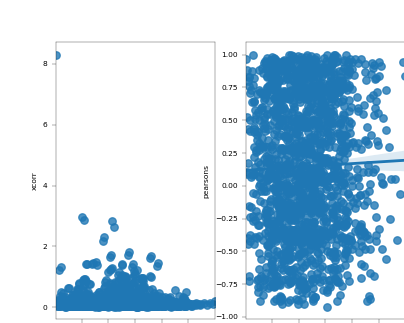

<AxesSubplot:xlabel='cortical_distance', ylabel='pearsons'>

In [238]:
fig, axn = pl.subplots(1,2)
ax=axn[0]
sns.regplot(x='cortical_distance', y='xcorr', data=adist, ax=ax)
ax=axn[1]
sns.regplot(x='cortical_distance', y='pearsons', data=adist, ax=ax)

<IPython.core.display.Javascript object>


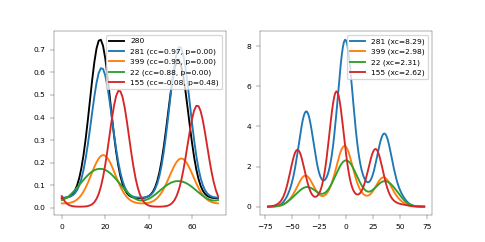

In [240]:
%matplotlib notebook
r1 = 280
#r2 = 281

popt_r1 = fitdf[params].loc[r1]
fitr1 = osi.double_gaussian(thetas, *popt_r1)

fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
ax.plot(fitr1, label=r1, color='k')

for r2 in [281, 399,22, 155]: #[37, 361, 203]:
    popt_r2 = fitdf[params].loc[r2]
    fitr2 = osi.double_gaussian(thetas, *popt_r2)

    ccorr = signal.correlate(fitr1, fitr2)
    lags = signal.correlation_lags(len(fitr1), len(fitr2))
    cc, pv = spstats.pearsonr(fitr1, fitr2)
    
    axn[0].plot(fitr2, label='%i (cc=%.2f, p=%.2f)' % (r2, cc, pv))
    #ax.legend()
    lagzero = list(lags).index(0)
    xcorr = ccorr[lagzero]

    axn[1].plot(lags, ccorr, label='%i (xc=%.2f)' % (r2, xcorr))
    #axn[1].set_ylim([0, 1])
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, wspace=0.2)
axn[0].legend()
axn[1].legend()

In [177]:
lagzero = list(lags).index(0)
ccorr[lagzero]

0.31740199354193777

In [178]:
spstats.pearsonr(fitr1, fitr2)

(-0.7388524872725079, 8.514938453605815e-14)

In [152]:
ccorr.max()

1.059285601326337

# Calcualte point differences

In [63]:
angdists = cr.aggregate_angular_dists(FITS, min_ncells=5)

too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Li, 20190522_JC089_fov1
too few cells: Li, 20190617_JC099_fov1
too few cells: Li, 20191105_JC117_fov1
too few cells: Li, 20191111_JC120_fov1
too few cells: Lm, 20191105_JC117_fov1


In [64]:
df = angdists.copy()

<IPython.core.display.Javascript object>


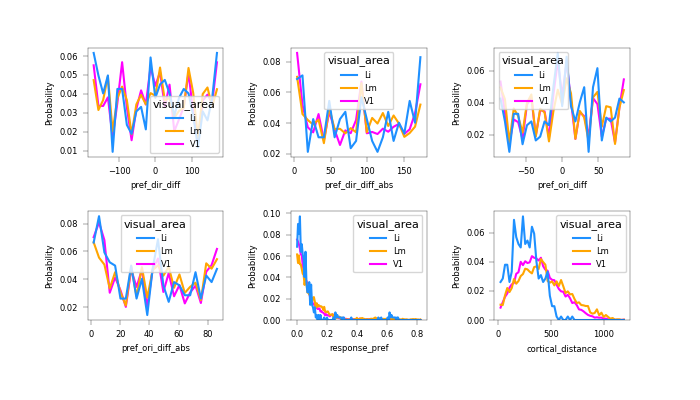

In [65]:
%matplotlib notebook
# plotd = angdists.copy()
plotd = df.dropna().copy()
plot_list = ['pref_dir_diff', 'pref_dir_diff_abs', 
             'pref_ori_diff', 'pref_ori_diff_abs','response_pref',
            'cortical_distance']
fig, axn =pl.subplots(2, int(len(plot_list)/2), figsize=(7,4))
for ax, par in zip(axn.flat, plot_list):
    sns.histplot(x=par, data=plotd, ax=ax, common_norm=False,
            hue='visual_area', palette=area_colors, stat='probability',
            element='poly', fill=False)
pl.subplots_adjust(bottom=0.2, wspace=0.5, hspace=0.5)

In [59]:
np.arange(0, )

array([], dtype=int64)

In [67]:
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

<IPython.core.display.Javascript object>


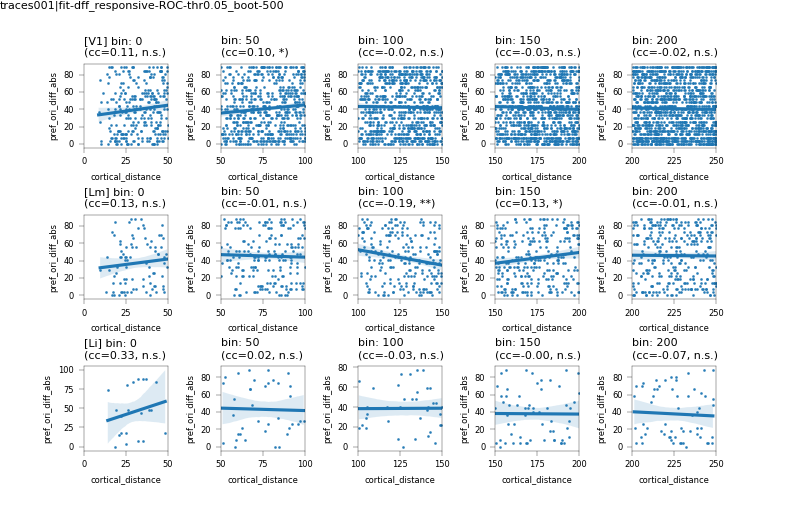

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs_v_binCTX_50um


In [80]:
%matplotlib notebook
y_var='pref_ori_diff_abs'
dist_var = 'cortical_distance'
scatter_kws={'s': 1}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,5.3))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([ctx_bins[di], ctx_bins[di+1]])
        ax.set_xticks(np.linspace(ctx_bins[di], ctx_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_binCTX_%ium' % (y_var, ctx_step)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## Compare with signal corrs

In [81]:
SDF = aggr.check_sdfs(NDATA['datakey'].unique(), experiment=experiment,
                      images_only=False,rename=False, 
                      return_incorrect=False, return_all=False)
select_stimuli='fullfield'
distance_var = 'rf_distance'
min_ncells=10
CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, rfdf=None,
                        SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

Checking gratings configs
Dist: cortical_distance
Skipping - (Li, 20190321_JC070_fov2)
Skipping - (Li, 20191105_JC117_fov1)
Skipping - (Lm, 20191105_JC117_fov1)
8 datasets w wrong configs:
    ('Li', '20190314_JC070_fov1')
    ('Li', '20190315_JC070_fov2')
    ('Li', '20190522_JC089_fov1')
    ('Lm', '20190306_JC061_fov2')
    ('Lm', '20190512_JC083_fov1')
    ('Lm', '20190513_JC078_fov1')
    ('V1', '20190511_JC083_fov1')
    ('V1', '20190512_JC083_fov1')
0 datasets w/out RF fits:


In [83]:
ign_cols =  ['experiment', 'signal_cc', 'noise_cc', 'n_cells']
cc_cols = [k for k in CORRS.columns if k not in ign_cols]
# DF = pd.merge(angdists, ccdf, on=cc_cols, how='inner')
ccdf = pd.merge(angdists, CORRS, on=cc_cols, how='inner')

In [ ]:
# 

In [91]:
df = ccdf.copy()

In [92]:
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

In [86]:
angdists.shape

(19409, 13)

<IPython.core.display.Javascript object>


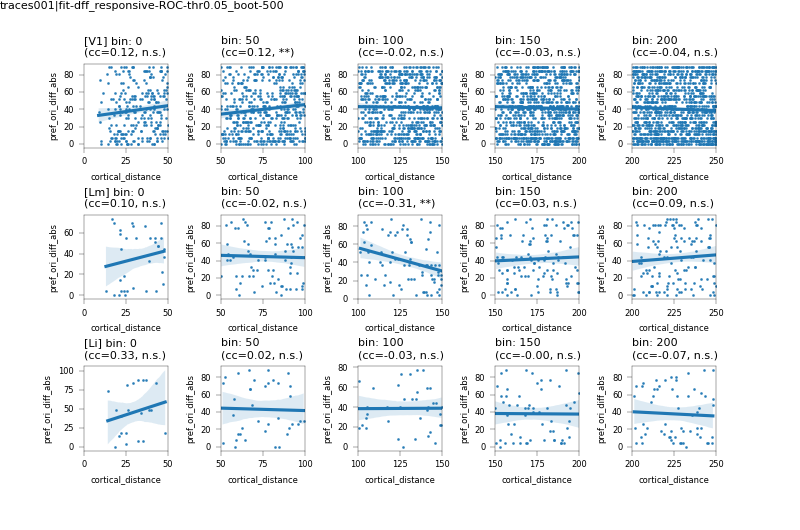

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs_v_binCTX_50um_cc


In [93]:
%matplotlib notebook
y_var='pref_ori_diff_abs'
dist_var = 'cortical_distance'
scatter_kws={'s': 1}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,5.3))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([ctx_bins[di], ctx_bins[di+1]])
        ax.set_xticks(np.linspace(ctx_bins[di], ctx_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_binCTX_%ium_cc' % (y_var, ctx_step)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [119]:
df = ccdf.copy()
# --------------------------------------------------
metric = 'pref_ori_diff_abs'
m_bins = np.linspace(0, 90, 9)
df = cr.cut_bins(df, m_bins, metric=metric)

ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')